In [1]:
import time
start = time.time()

import pandas as pd
import gc

!pip install numerapi
from numerapi import NumerAPI

import numpy as np

import matplotlib.pyplot as plt
import pyarrow.parquet as pq

from sklearn.linear_model import Ridge
from sklearn.feature_selection import SelectKBest, f_regression


TOURNAMENT_NAME= "first_large"
ERA_COL = "era"
TARGET_COL = "target_nomi_v4_20"
DATA_TYPE_COL = "data_type"
EXAMPLE_PREDS_COL = "example_preds"
PREDICTION_NAME = "prediction"

TOP_K_FEATURES = 100

napi = NumerAPI()



In [2]:
# utilities

from utils import load_stuff, save_stuff



In [3]:
# scoring analysis
# Submissions are scored by Spearman correlation
def score(df):
    return df[[TARGET_COL, PREDICTION_NAME]].corr(method="spearman")[TARGET_COL][PREDICTION_NAME]

def spearmanr(target, pred):
    return np.corrcoef(
        target,
        pred.rank(pct=True, method="first")
    )[0, 1]

def ar1(x):
    return np.corrcoef(x[:-1], x[1:])[0,1]

def autocorr_penalty(x):
    n = len(x)
    p = ar1(x)
    return np.sqrt(1 + 2*np.sum([((n - i)/n)*p**i for i in range(1,n)]))

def smart_sharpe(x):
    return np.mean(x)/(np.std(x, ddof=1)*autocorr_penalty(x))

def numerai_sharpe(x):
    return ((np.mean(x) - 0.010415154) / np.std(x)) * np.sqrt(12)


def get_basic_per_era_metrics(df:pd.DataFrame,fig_name="per_era_scores.png") -> pd.Series:
    """
    Some metrics related to per-era scores.
    Plots per-era mean correlation with `TARGET_NAME` column

    more metrics at: https://forum.numer.ai/t/more-metrics-for-ya/636

    Parameters
    ----------
    df : pd.DataFrame
        Training or Tournament DataFrame having predictions assigned
        at `PREDICTION_NAME` column.

    fig_name: str, optional, default:per_era_scores.png
        Name for per-era correlation graph to be saved with extension.
        prefix will be added to the file name based on `data_type`.

    Returns:
    ------
    pd.Series: Pandas Series having per-era metrics

    """

    prefix=None
    scores = pd.Series(dtype=float)
    preds_ = df[PREDICTION_NAME]


    #-----------------------------------------------------

    #Metric Calculations
    print("getting per era scores")
    era_scores = df.groupby("era").apply(
        lambda x: spearmanr(x[TARGET_COL], x[PREDICTION_NAME]))

    era_scores.sort_index(inplace=True)
    era_scores.plot(kind="bar")
    print("performance over time")
    plt.savefig(f"{prefix}_{fig_name}")
    plt.show()

    #-----------------------------------------------------

    scores[f"{prefix}_mean"] = preds_.mean()
    scores[f"{prefix}_std_dev"] = preds_.std()
    scores[f"{prefix}_less_than_half"] = (preds_<0.5).mean()
    scores[f"{prefix}_less_than_mean"] = (preds_<preds_.mean()).mean()

    scores[f"{prefix}_autocorrelation"] = ar1(era_scores)
    scores[f"{prefix}_mean correlation"] = np.mean(era_scores)
    scores[f"{prefix}_Median Correlation"] = np.median(era_scores)
    scores[f"{prefix}_Variance"] = np.var(era_scores)
    scores[f"{prefix}_Std. Dev."] = np.std(era_scores)
    scores[f"{prefix}_sharpe"] = np.mean(era_scores)/np.std(era_scores)
    scores[f"{prefix}_smart sharpe"] = smart_sharpe(era_scores)
    scores[f"{prefix}_Numerai sharpe"] = numerai_sharpe(era_scores)

    print(scores)
    del era_scores
    del preds_
    gc.collect()
    return scores





2022-10-30 01:38:10,281 INFO numerapi.utils: target file already exists
2022-10-30 01:38:10,282 INFO numerapi.utils: download complete
2022-10-30 01:38:10,748 INFO numerapi.utils: target file already exists
2022-10-30 01:38:10,749 INFO numerapi.utils: download complete
2022-10-30 01:38:11,152 INFO numerapi.utils: target file already exists
2022-10-30 01:38:11,153 INFO numerapi.utils: download complete
2022-10-30 01:38:11,580 INFO numerapi.utils: target file already exists
2022-10-30 01:38:11,580 INFO numerapi.utils: download complete
2022-10-30 01:38:11,966 INFO numerapi.utils: target file already exists
2022-10-30 01:38:11,966 INFO numerapi.utils: download complete


Checking for existing model 'model_target'
model not found, creating new one
saving new model, features: model_target
Reading features of validation and tournament data...
No nans in the features this week!
Predicting on validation and tournament data
On training the correlation has mean 0.046863539465057454 and std 0.030245546396469262
On validation the correlation has mean 0.012917401988308486 and std 0.02763446741301209
getting per era scores
performance over time


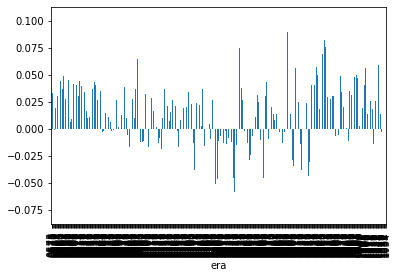

None_mean                  0.500001
None_std_dev               0.010736
None_less_than_half        0.499303
None_less_than_mean        0.499329
None_autocorrelation            NaN
None_mean correlation      0.013825
None_Median Correlation         NaN
None_Variance              0.000716
None_Std. Dev.             0.026761
None_sharpe                0.516610
None_smart sharpe               NaN
None_Numerai sharpe        0.441368
dtype: float64
done in 1.512793246905009 mins


In [4]:


current_round = napi.get_current_round(tournament=8)  # tournament 8 is the primary Numerai Tournament

# Tournament data changes every week so we specify the round in their name. Training
# and validation data only change periodically, so no need to download them every time.
print('Downloading dataset files...')
#napi.download_dataset("numerai_training_data.parquet", "training_data.parquet")
#napi.download_dataset("numerai_tournament_data.parquet", f"tournament_data_{current_round}.parquet")
#napi.download_dataset("numerai_validation_data.parquet", f"validation_data.parquet")
#napi.download_dataset("example_validation_predictions.parquet", "example_validation_predictions.parquet")
#napi.download_dataset("features.json", "features.json")


napi.download_dataset("v4/train.parquet","training_data.parquet")
napi.download_dataset("v4/validation.parquet",f"validation_data.parquet")
napi.download_dataset("v4/live.parquet", f"tournament_data_{current_round}.parquet")
napi.download_dataset("v4/validation_example_preds.parquet","example_validation_predictions.parquet")
napi.download_dataset("v4/features.json","features.json")


# read in just those features along with era and target columns

training_data = pq.read_table('training_data.parquet').to_pandas()

features = [ f for f in training_data.columns if f.startswith("feature")]

X = training_data[features]
Y = training_data[TARGET_COL]



# pare down the number of eras to every 4th era
# every_4th_era = training_data[ERA_COL].unique()[::4]
# training_data = training_data[training_data[ERA_COL].isin(every_4th_era)]


# "garbage collection" (gc) gets rid of unused data and frees up memory
gc.collect()

#feature_names = [ f for f in training_data.columns if f.startswith("feature")]

model_name = f"model_target"
print(f"Checking for existing model '{model_name}'")
model = load_stuff(model_name)
selected_features = load_stuff('features')
if not model:
    print(f"model not found, creating new one")
    
    selector = SelectKBest(f_regression, k = TOP_K_FEATURES)
    selector.fit(X, Y)
    select = X.columns[selector.get_support()]
    selected_features = select.tolist()

    read_columns = selected_features + [ERA_COL, DATA_TYPE_COL, TARGET_COL]
    training_data = pd.read_parquet('training_data.parquet', columns=read_columns)
    
    feature_names = [ f for f in training_data.columns if f.startswith("feature")]

    X = training_data[feature_names]
    Y = training_data[TARGET_COL]

    model = Ridge(alpha=0.9)

    model.fit(X, Y)
    print(f"saving new model, features: {model_name}")
    save_stuff(model,model_name)
    save_stuff(selected_features,'features')

gc.collect()


print('Reading features of validation and tournament data...')
read_columns = selected_features + [ERA_COL, DATA_TYPE_COL, TARGET_COL]

validation_data = pq.read_table('validation_data.parquet').to_pandas()
tournament_data = pq.read_table(f"tournament_data_{current_round}.parquet").to_pandas()

target_columns = [col for col in tournament_data if 'target' in col]
tournament_data.drop(columns=target_columns, inplace=True)
nans_per_col = tournament_data[tournament_data["data_type"] == "live"].isna().sum()


# check for nans and fill nans
if nans_per_col.any():
    total_rows = len(tournament_data[tournament_data["data_type"] == "live"])
    print(f"Number of nans per column this week: {nans_per_col[nans_per_col > 0]}")
    print(f"out of {total_rows} total rows")
    print(f"filling nans with 0.5")
    tournament_data.loc[:, feature_names].fillna(0.5, inplace=True)
else:
    print("No nans in the features this week!")


print('Predicting on validation and tournament data')
# double check the feature that the model expects vs what is available to prevent our
# pipeline from failing if Numerai adds more data and we don't have time to retrain!
#model_expected_features = model.feature_names_in_

model_expected_features = selected_features

#here we only use top K features, so we don't detect a change in features
#if set(model_expected_features) != set(feature_names):
#    print(f"New features are available! Might want to retrain model {model_name}.")

training_data[PREDICTION_NAME] = model.predict(training_data[model_expected_features])
validation_data[PREDICTION_NAME] = model.predict(validation_data[model_expected_features])
tournament_data[PREDICTION_NAME] = model.predict(tournament_data[model_expected_features])


gc.collect()


validation_data[PREDICTION_NAME].to_csv(f"validation_predictions_{current_round}.csv")
tournament_data[PREDICTION_NAME].to_csv(f"tournament_predictions_{current_round}.csv")

validation_preds = pq.read_table("example_validation_predictions.parquet").to_pandas()
validation_data[EXAMPLE_PREDS_COL] = validation_preds["prediction"]


train_correlations = training_data.groupby("era").apply(score)
print( f"On training the correlation has mean {train_correlations.mean()} and std {train_correlations.std()}")

# Check the per-era correlations on the validation set

validation_correlations = validation_data.groupby("era").apply(score)
print(f"On validation the correlation has mean {validation_correlations.mean()} and std {validation_correlations.std()}")

scores = get_basic_per_era_metrics(validation_data)
  

print(f'done in {(time.time() - start) / 60} mins')




In [5]:
id = "OML65REYFDPC5O7N22XCRP44BG2M74XH"
key = "YSTL455VERL7WZ4D7OQ6XEYEQN2MRCCICBMILNFP3DUZC4MSAS2WSH2MV7ED6WB3"

napi = NumerAPI(public_id=id,secret_key=key)

path =  f"tournament_predictions_{current_round}.csv"

#print('uploading')
#napi.upload_predictions(file_path=path,version=2)

